In [51]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
from plot_field import generate_afl_oval, plot_events
import seaborn as sns
import matplotlib.pyplot as plt

venueWidth = (123/2)
venueLength = (167/2)
venueDims = (-venueLength, venueLength, -venueWidth, venueWidth)
defaultVenue = 'Adelaide Oval'

# Next position
chains_processed =  pd.read_pickle("../data/chains_processed.pkl")
# 1. Record scores against kicks

chains_processed['points'] = np.select([chains_processed.description == "Goal", chains_processed.description == "Behind"], [6, 1], default=np.NaN)
chains_processed['points'] = chains_processed['points'].shift(-1)

# 2. Reset goal positions
finCondList = [chains_processed.description == "Goal",
            chains_processed.behindInfo =='missLeft',
            chains_processed.behindInfo =='leftPost',
            chains_processed.behindInfo =='missRight',
            chains_processed.behindInfo =='touched',
            chains_processed.behindInfo =='rightPost']
## Y next pos
finychoiceList = [0,
              6.4,
              3.2,
              -6.4,
              0,
              -3.2]
## X next pos
finxchoiceList = [167/2] * 6

## Record condition for debugging
nextCondChoice = ['G',
                 'ML',
                 'LP',
                 'MR',
                 'Touched',
                 'RP']

chains_processed = chains_processed.assign(x = np.select(finCondList, finxchoiceList, default=chains_processed.x),
                                           y = np.select(finCondList, finychoiceList, default=chains_processed.y),
                                           Cond = np.select(finCondList, nextCondChoice, default='Def'))

chains_processed['shotAtGoal'] = chains_processed.shotAtGoal.replace(np.NaN,False)

chains_processed['x'] = np.where(chains_processed.description == "Goal", (167/2), chains_processed.x)
chains_processed['y'] = np.where(chains_processed.description == "Goal", 0, chains_processed.y)
# 2. shift next pos
chains_processed['x_next'] = chains_processed.groupby(['season', 'roundNumber', 'homeTeam', 'period'], as_index=False)['x'].shift(-1)
chains_processed['y_next'] = chains_processed.groupby(['season', 'roundNumber', 'homeTeam', 'period'], as_index=False)['y'].shift(-1)

# 3. Reverse position for turnovers
finCondList = ((chains_processed.description == 'Spoil') & (~chains_processed.playingFor.shift(-1).isnull()) & \
    (~chains_processed.playingFor.shift(1).eq(chains_processed.playingFor.shift(-1)))) | \
    (chains_processed.possChng & chains_processed.finalPos & \
              (chains_processed.finalState.isin(["turnover", 'rushed'])) & \
              (chains_processed.description != 'Out On Full After Kick') & \
              (chains_processed.description.shift(-1) != 'Spoil'))

fCondTemp = [(chains_processed.description == 'Spoil') &  (~chains_processed.playingFor.shift(-1).isnull()) & \
    (~chains_processed.playingFor.shift(1).eq(chains_processed.playingFor.shift(-1))), 
    (chains_processed.possChng & chains_processed.finalPos & \
              (chains_processed.finalState.isin(["turnover", 'rushed'])) & \
              (~chains_processed.description.isin(['Out On Full', 'Out On Full After Kick'])) & \
              (chains_processed.description.shift(-1) != 'Spoil'))]

# chains_processed = chains_processed.assign(x_next = np.where(finCondList, -chains_processed.x_next, chains_processed.x_next),
#                                            y_next = np.where(finCondList, -chains_processed.y_next, chains_processed.y_next),
#                                            Cond2 = np.select(fCondTemp, ['TO1', 'TO2'], 'Def'))

# 3. Set kickin as middle of the goal square
chains_processed['x'] = np.where(chains_processed.description.str.contains('Kickin') & chains_processed.description.shift(1).isin(['Goal', 'Behind']), -venueLength + 5, chains_processed.x)
chains_processed['y'] = np.where(chains_processed.description.str.contains('Kickin') & chains_processed.description.shift(1).isin(['Goal', 'Behind']), 0, chains_processed.y)

# 4. Remove game events
game_events = ['Out On Full After Kick', 'Out On Full', 'Out of Bounds', 'Ball Up Call', 'Goal', 'Behind','Kick Inside 50 Result', 'OOF Kick In']

chains_processed = chains_processed[~chains_processed.description.isin(game_events)]


# 5. Calculate distance for QA
def calc_dist(x0, y0, x1, y1):
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    x1 = np.array(x1, dtype=float)
    y1 = np.array(y1, dtype=float)
    return np.sqrt((x1-x0)**2 + (y1 - y0)**2)

chains_processed = chains_processed.assign(possDist = calc_dist(chains_processed.x, chains_processed.y, chains_processed.x_next, chains_processed.y_next))


In [52]:
bin_period = 25

venueWidth = (123/2)
venueLength = (167/2)
venueDims = (-venueLength, venueLength, -venueWidth, venueWidth)


def bin_values(col, dir='x'):
    if dir == 'x':
        s = -venueLength; e = venueLength
    else:
        s = -venueWidth; e = venueWidth
    return pd.cut(col.values, pd.interval_range(start=s, end=e, periods=bin_period, closed='right'), include_lowest=True, precision=2)

x_bins = pd.interval_range(start=-venueLength, end=venueLength, periods=bin_period, closed='right')
y_bins = pd.interval_range(start=-venueWidth, end=venueWidth, periods=bin_period, closed='right')

chains_processed = chains_processed.assign(xInitialPoss_bin=bin_values(chains_processed.x, 'x'),
                                                yInitialPoss_bin=bin_values(chains_processed.y, 'y'),
                                                xFinalPoss_bin=bin_values(chains_processed.x_next, 'x'),
                                                yFinalPoss_bin=bin_values(chains_processed.y_next, 'y'))

disposal_actions = ['Kick', 'Handball', 'Ground Kick', 'Kickin short', 'Kickin long', 'Kickin play on']

movement_df = chains_processed[chains_processed.description.isin(disposal_actions)]

In [34]:
movement_df

,season,roundNumber,homeTeam,awayTeam,homeTeamScore,awayTeamScore,date,venueName,venueWidth,venueLength,homeTeamDirectionQtr1,displayOrder,chainNumber,initialState,finalState,period,periodSeconds,playingFor,playerId,firstName,surname,position,description,disposal,shotAtGoal,behindInfo,x,y,chainId,possessionNum,possessionId,x_norm,y_norm,possChng,endOfQtr,finalPos,points,Cond,x_next,y_next,possDist,xInitialPoss_bin,yInitialPoss_bin,xFinalPoss_bin,yFinalPoss_bin
2,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,3,1,centreBounce,ballUpCall,1,11,Richmond,CD_I993903,Jacob,Hopper,MIDFIELDER,Handball,ineffective,False,NaN,-2.0,0.0,2023_1_Richmond_C1,1,2023_1_Richmond_C1_P1,-2.08750,0.000000,False,False,False,NaN,Def,-3.0,0.0,1.000000,"(-3.3400000000000034, 3.3400000000000034]","(-2.460000000000001, 2.460000000000001]","(-3.3400000000000034, 3.3400000000000034]","(-2.460000000000001, 2.460000000000001]"
5,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,6,2,ballUp,goal,1,26,Richmond,CD_I298174,Toby,Nankervis,RUCK,Kick,clanger,False,NaN,-8.0,-7.0,2023_1_Richmond_C2,1,2023_1_Richmond_C2_P1,-8.35000,-6.106383,False,False,False,NaN,Def,46.0,-5.0,54.037024,"(-10.02000000000001, -3.3400000000000034]","(-7.380000000000003, -2.460000000000001]","(43.41999999999999, 50.099999999999994]","(-7.380000000000003, -2.460000000000001]"
11,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,12,2,ballUp,goal,1,32,Richmond,CD_I290847,Dustin,Martin,MEDIUM_FORWARD,Kick,effective,True,NaN,52.0,-5.0,2023_1_Richmond_C2,2,2023_1_Richmond_C2_P2,54.27500,-4.361702,False,False,True,6.0,Def,83.5,0.0,31.894357,"(50.099999999999994, 56.78]","(-7.380000000000003, -2.460000000000001]","(76.82, 83.5]","(-2.460000000000001, 2.460000000000001]"
15,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,16,3,centreBounce,goal,1,96,Carlton,CD_I1004912,Tom,De Koning,RUCK,Handball,effective,False,NaN,0.0,2.0,2023_1_Richmond_C3,1,2023_1_Richmond_C3_P1,0.00000,1.744681,False,False,False,NaN,Def,4.0,-5.0,8.062258,"(-3.3400000000000034, 3.3400000000000034]","(-2.460000000000001, 2.460000000000001]","(3.3400000000000034, 10.019999999999996]","(-7.380000000000003, -2.460000000000001]"
17,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,right,18,3,centreBounce,goal,1,99,Carlton,CD_I1002239,Adam,Cerra,MIDFIELDER,Kick,effective,False,NaN,11.0,-6.0,2023_1_Richmond_C3,2,2023_1_Richmond_C3_P2,11.48125,-5.234043,False,False,False,NaN,Def,58.0,-7.0,47.010637,"(10.019999999999996, 16.69999999999999]","(-7.380000000000003, -2.460000000000001]","(56.78, 63.45999999999998]","(-7.380000000000003, -2.460000000000001]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326450,2023,19,Richmond,Hawthorn,96,95,2023-07-22,MCG,141,160,left,2094,259,ballUp,turnover,4,1791,Richmond,CD_I1000223,Liam,Baker,MEDIUM_DEFENDER,Kick,effective,False,NaN,-21.0,-20.0,2023_19_Richmond_C259,2,2023_19_Richmond_C259_P2,-21.91875,-17.446809,False,False,False,NaN,Def,-14.0,-3.0,18.384776,"(-23.380000000000003, -16.700000000000003]","(-22.14, -17.22]","(-16.700000000000003, -10.02000000000001]","(-7.380000000000003, -2.460000000000001]"
326452,2023,19,Richmond,Hawthorn,96,95,2023-07-22,MCG,141,160,left,2096,259,ballUp,turnover,4,1801,Richmond,CD_I993771,Marlion,Pickett,MIDFIELDER_FORWARD,Kick,effective,False,NaN,-23.0,-1.0,2023_19_Richmond_C259,3,2023_19_Richmond_C259_P3,-24.00625,-0.872340,False,False,False,NaN,Def,-39.0,-9.0,17.888544,"(-23.380000000000003, -16.700000000000003]","(-2.460000000000001, 2.460000000000001]","(-43.42, -36.74]","(-12.299999999999997, -7.380000000000003]"
326454,2023,19,Richmond,Hawthorn,96,95,2023-07-22,MCG,141,160,left,2098,259,ballUp,turnover,4,1804,Richmond,CD_I295203,Nathan,Broad,MEDIUM_DEFENDER,Kick,effective,False,NaN,-43.0,-9.0,2023_19_Richmond_C259,4,2023_19_Richmond_C259_P4,-44.88125,-7.851064,False,False,False,NaN,

See here - https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_ExpectedThreat.html

## Step 1

Select only positive disposal type actions

TO DO: Include turnovers, out of bounds


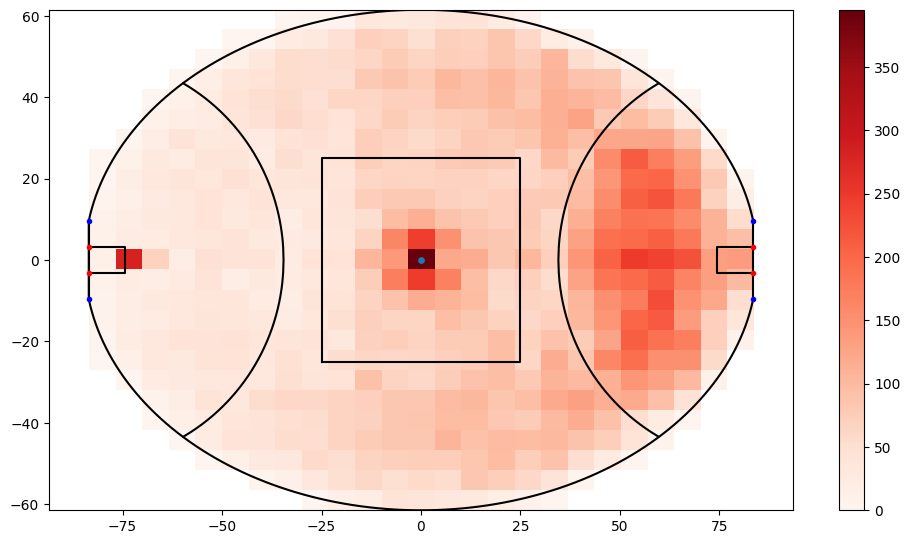

In [35]:
possession_summary = pd.read_pickle("../data/possessions_processed_norm.pkl")

bin_period = 25

venueWidth = (123/2)
venueLength = (167/2)
venueDims = (-venueLength, venueLength, -venueWidth, venueWidth)


def bin_values(col, dir='x'):
    if dir == 'x':
        s = -venueLength; e = venueLength
    else:
        s = -venueWidth; e = venueWidth
    return pd.cut(col.values, pd.interval_range(start=s, end=e, periods=bin_period, closed='right'), include_lowest=True, precision=2)

x_bins = pd.interval_range(start=-venueLength, end=venueLength, periods=bin_period, closed='right')
y_bins = pd.interval_range(start=-venueWidth, end=venueWidth, periods=bin_period, closed='right')

possession_summary = possession_summary.assign(xInitialPoss_bin=bin_values(possession_summary.xInitialPoss, 'x'),
                                                yInitialPoss_bin=bin_values(possession_summary.yInitialPoss, 'y'))

possession_summary['SAG'] = possession_summary.groupby(['chainId'])['shotAtGoal'].transform(lambda s: any(s.values))
plot_df = possession_summary.drop_duplicates(['possessionId','SAG']).groupby(['xInitialPoss_bin', 'yInitialPoss_bin']).SAG.apply(lambda s: sum(s.values)).rename('xG').reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
# plot_df.drop('shotAtGoal', inplace=True, axis=1)
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='xG')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(12, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Reds')

ax.set_xlim(-venueLength - 10, venueLength + 10)
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

In [53]:
all_count = movement_df[['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
move_count = movement_df[~movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
shot_count = movement_df[movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
score_count = movement_df.groupby(['xInitialPoss_bin','yInitialPoss_bin']).points.agg('sum')

move_probability = move_count.div(all_count, fill_value=0)
shot_probability = shot_count.div(all_count, fill_value=0)
score_probability = score_count.div(shot_count, fill_value=0).div(all_count.apply(lambda x: 1), fill_value=1).replace(np.NaN, 0)
score_probability = score_probability.rename('xG')

C:\Users\Dave Scroggs\AppData\Local\Temp\ipykernel_18724\524239923.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_df = movement_df[~(chains_processed.description == "Kickin play on")][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()


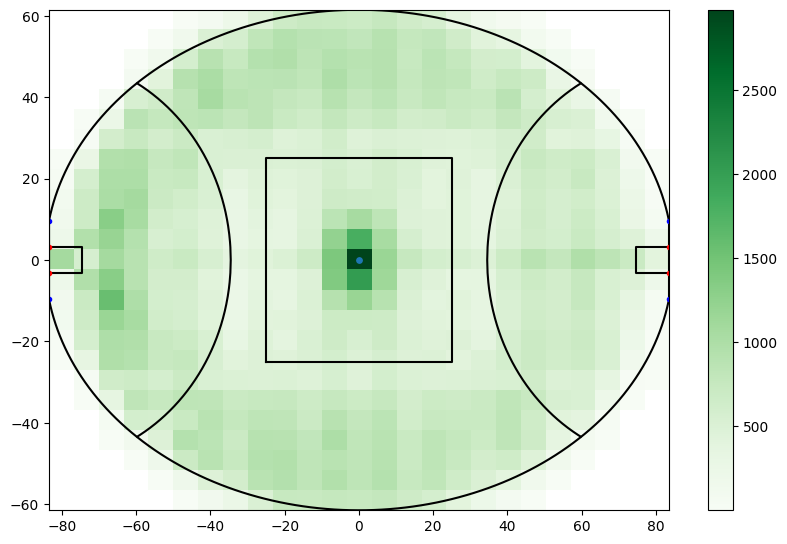

In [54]:
plot_df = movement_df[~(chains_processed.description == "Kickin play on")][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df = plot_df.pivot(index='y', columns='x', values='count')

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Greens')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

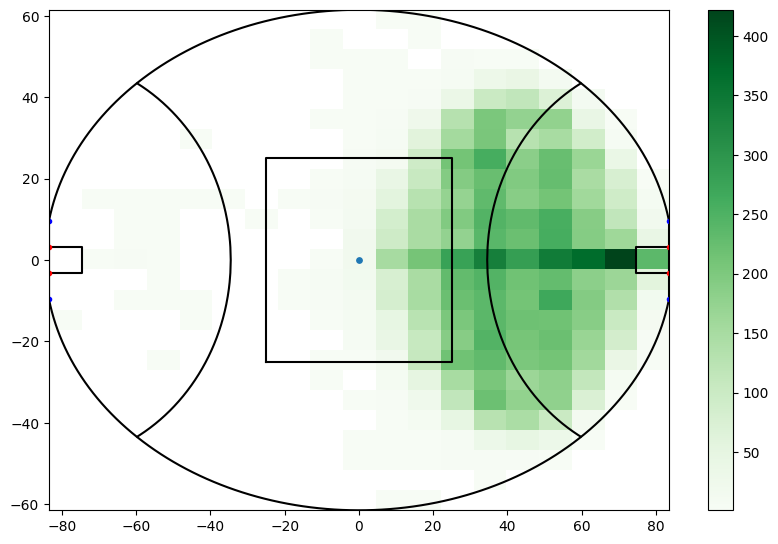

In [55]:
plot_df = movement_df[movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Greens')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

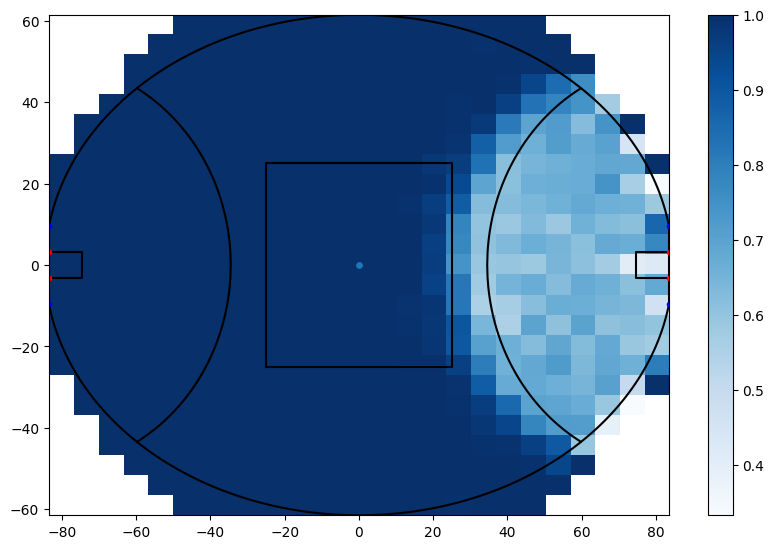

In [39]:
plot_df = move_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Blues')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

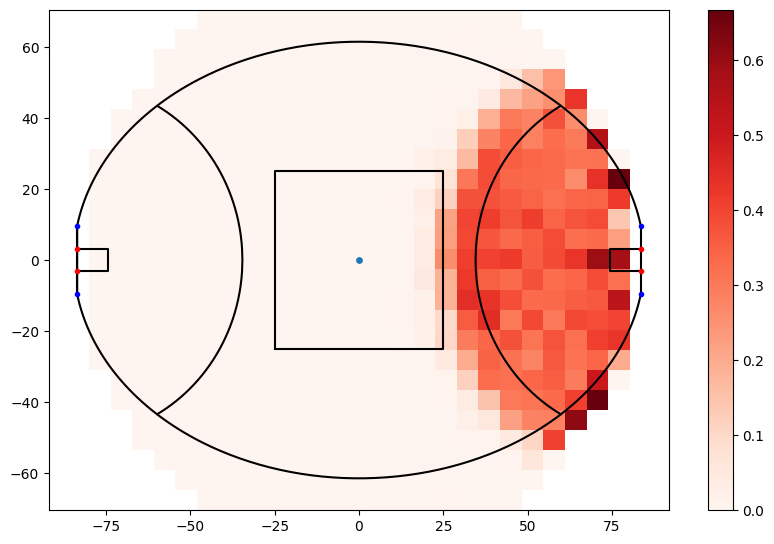

In [40]:
plot_df = shot_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=(-80,80, -70.5, 70.5), 
          cmap='Reds')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

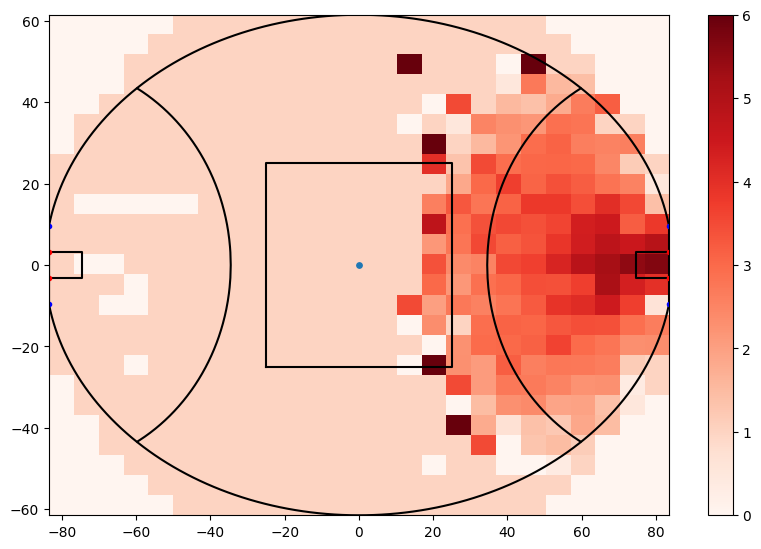

In [41]:
plot_df = score_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='xG')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Reds')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

## Transition matricies

In [56]:
transitions = chains_processed.value_counts(['xInitialPoss_bin','yInitialPoss_bin','xFinalPoss_bin', 'yFinalPoss_bin']).rename('total_events')

move_shot = chains_processed.groupby(['xInitialPoss_bin','yInitialPoss_bin']).aggregate(shots = ('shotAtGoal', sum),
                                                                           points = ('points', sum),
                                                                           total_events = ('possessionNum', 'size'))
move_shot['xG'] = move_shot.points/move_shot.shots
move_shot['xG'] = move_shot['xG'].replace(np.NaN,0)
move_shot['move_prob'] = 1 - move_shot.shots/move_shot.total_events
move_shot['move_prob'] = move_shot['move_prob'].replace(np.NaN,0)
move_shot['shotXp'] = (1-move_shot.move_prob) * move_shot.xG


In [58]:
# Create a data frame with the final position indexs and set all values to 0
xT = chains_processed.groupby(['xFinalPoss_bin', 'yFinalPoss_bin']).x.count().apply(lambda x: 0)

for i in range(8):
    xT_start = xT
    tX = transitions.div(move_shot.total_events, fill_value=0).replace(np.NaN, 0)
    tX = tX.mul(xT).groupby(['xInitialPoss_bin','yInitialPoss_bin']).sum()
    xT = move_shot.shotXp + move_shot.move_prob * tX
    # print("Diff: ", sum(abs(xT - xT_start)))
    

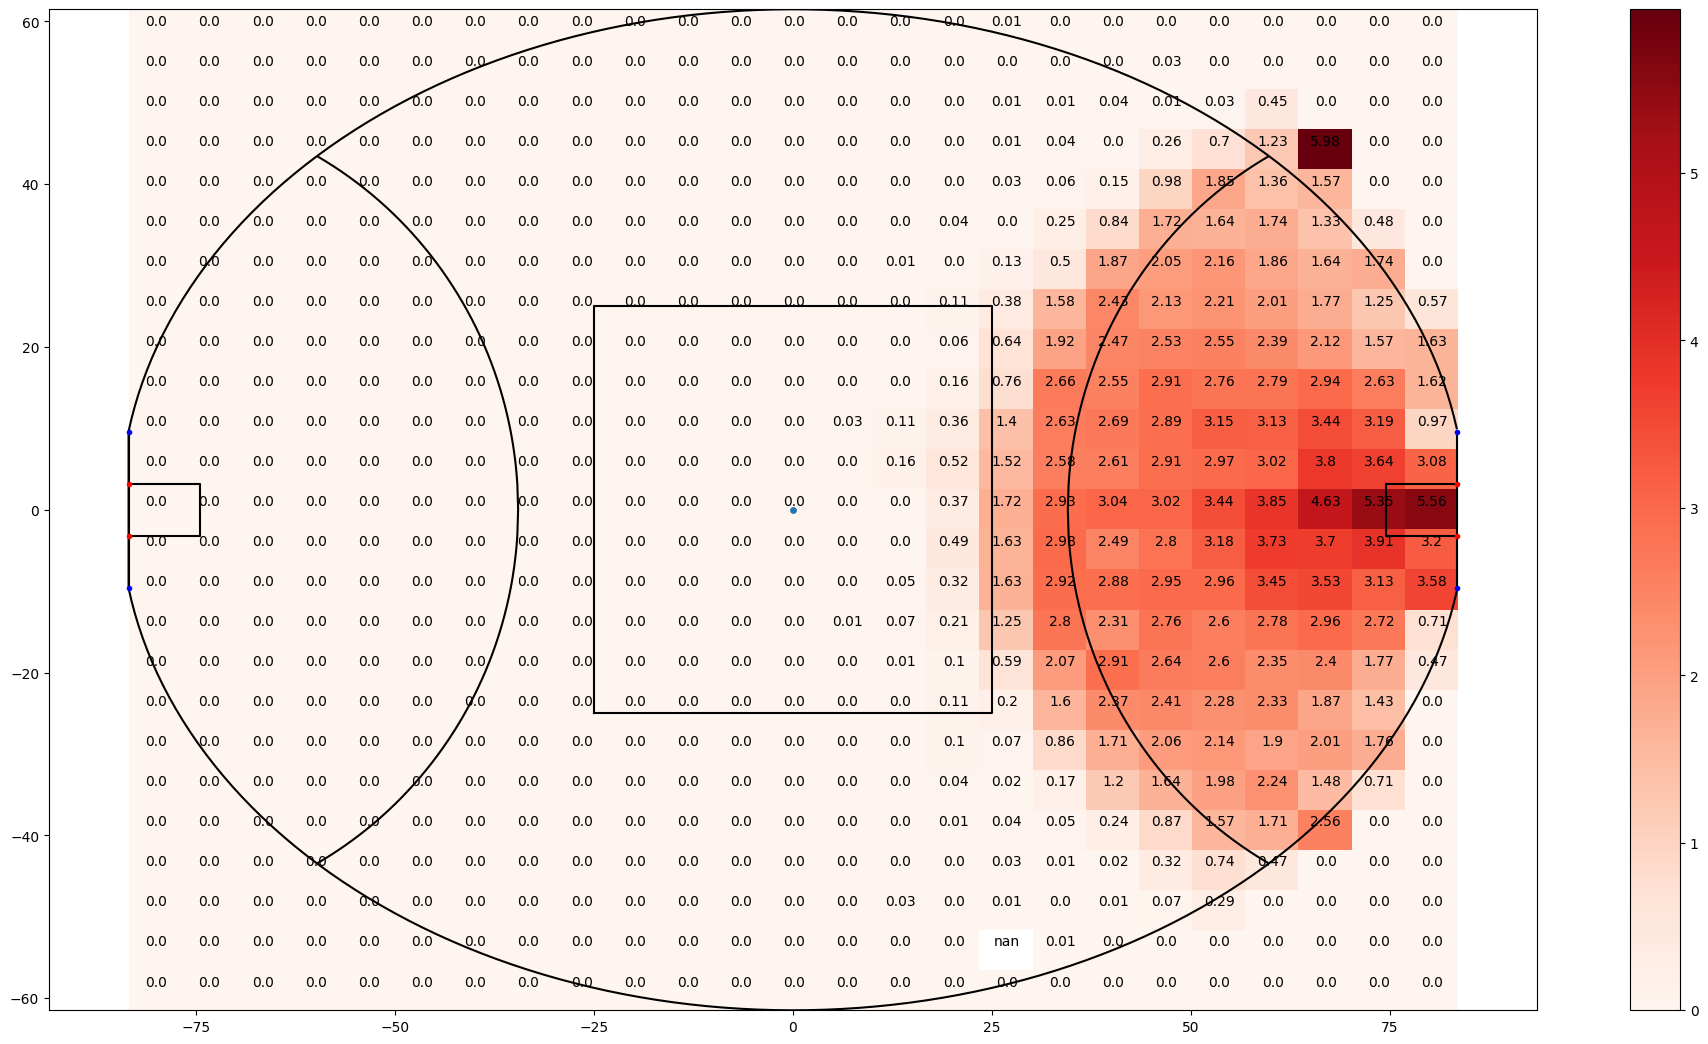

In [68]:
plot_df = xT.rename('xG').reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.pivot(index='y', columns='x', values='xG').sort_values(by='y',ascending=False)
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(24, 13))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Reds')

# Loop over data dimensions and create text annotations.
for i in plot_df.columns:
    for j in plot_df.index:
        text = ax.text(i + 3.5, j + 3.5, np.round(plot_df.loc[j, i],2),
                       ha="center", va="center", color="k")

ax.set_xlim(-venueLength - 10, venueLength + 10)
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

## Assigning xThreat

In [60]:
xT_df = (movement_df
        .merge(xT.rename('xT_start').reset_index(), how='left', on=['xInitialPoss_bin', 'yInitialPoss_bin'])
        .merge(xT.reset_index().rename(columns={0: 'xT_end','xInitialPoss_bin': 'xFinalPoss_bin', 'yInitialPoss_bin': 'yFinalPoss_bin'}), how='left', on=['xFinalPoss_bin', 'yFinalPoss_bin'])
        .drop(['xInitialPoss_bin', 'yInitialPoss_bin', 'xFinalPoss_bin', 'yFinalPoss_bin'], axis=1)
        )
xT_df['deltaXT'] = xT_df.xT_end - xT_df.xT_start

xT_df.to_pickle("../data/xT.pkl")

In [61]:
t = xT_df.groupby(['season', 'playingFor','playerId',	'firstName', 'surname']).deltaXT.sum().sort_values(ascending=False)
t.head(20)

season  playingFor        playerId     firstName  surname    
2023    Carlton           CD_I996731   Charlie    Curnow         379.513070
        Sydney Swans      CD_I1013128  Errol      Gulden         337.186464
2022    Melbourne         CD_I298210   Christian  Petracca       328.559161
        Sydney Swans      CD_I1012014  Chad       Warner         325.750696
2023    Richmond          CD_I993993   Shai       Bolton         320.921382
2022    Geelong Cats      CD_I293845   Jeremy     Cameron        314.084183
2023    Brisbane Lions    CD_I294518   Joe        Daniher        305.034377
        Melbourne         CD_I298210   Christian  Petracca       303.616336
2022    Richmond          CD_I993993   Shai       Bolton         298.850504
        Carlton           CD_I996731   Charlie    Curnow         287.084350
2023    Adelaide Crows    CD_I280506   Taylor     Walker         286.636992
2022    Gold Coast Suns   CD_I298272   Touk       Miller         284.515813
2023    Port Adelaide     